In [40]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed, BatchNormalization
import numpy as np
import h5py
import matplotlib.pyplot as plt
from data_utils import get_data
from sklearn import preprocessing


In [41]:
# Load data from all .mat files, combine them, eliminate EOG signals, shuffle and 
# seperate training data, validation data and testing data.
# Also do mean subtraction on x.

data = get_data('../project_datasets',num_validation=100, num_test=0, subtract_mean=True, subtract_axis=1,
                transpose=True)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))

X_train: (2458, 1000, 22) 
y_train: (2458,) 
X_val: (100, 1000, 22) 
y_val: (100,) 
X_test: (0, 1000, 22) 
y_test: (0,) 


In [42]:
# substract data from list
range_select = 150
X_train = data.get('X_train')[:, :range_select, :]
y_train = data.get('y_train')
X_val = data.get('X_val')[:, :range_select, :]
y_val = data.get('y_val')
#X_test = data.get('X_test')
#y_test = data.get('y_test')

# get data dimension
N_train, T_train, C_train = X_train.shape
N_val, T_val, C_val = X_val.shape
#N_test, T_test, C_test = data.get('X_test').shape

# add dummy zeros for y classification
lb = preprocessing.LabelBinarizer()
lb.fit([0, 1, 2, 3,])
lb.classes_
y_train = lb.transform(y_train)
y_val = lb.transform(y_val)
#y_test = lb.transform(y_test)

print(X_train.shape)
print(X_val.shape)

(2458, 150, 22)
(100, 150, 22)


In [43]:
# # normalize data across the time sequence dimension only
# scaler = preprocessing.MinMaxScaler()
# for i in range(N_train):
#     scaler.fit(X_train[i,:,:])
#     X_train[i,:,:] = scaler.transform(X_train[i,:,:])
    
# for i in range(N_val):
#     scaler.fit(X_val[i,:,:])
#     X_val[i,:,:] = scaler.transform(X_val[i,:,:])

In [44]:
# construct X_total and y_total based on sub-sampling of X_train and y_train

# take sub-sampling on the time sequence to reduce dimension for RNN
sampling = 1

X_train = X_train.reshape(N_train,int(T_train/sampling), sampling, C_train)[:,:,0,:]
X_val = X_val.reshape(N_val,int(T_val/sampling), sampling, C_val)[:,:,0,:]
    
# get new data dimension
N_train, T_train, C_train = X_train.shape
N_val, T_val, C_val = X_val.shape

print('X_train: ', X_train.shape)
print('X_val: ', X_val.shape)

X_train:  (2458, 150, 22)
X_val:  (100, 150, 22)


In [45]:
# Expected input batch shape: (batch_size, timesteps, data_dim)
# Note that we have to provide the full batch_input_shape since the network is stateful.
# the sample of index i in batch k is the follow-up for the sample i in batch k-1.

# perhaps should try masking layer

data_dim = C_train
timesteps = T_train
num_classes = 4
batch_size = 100
num_epoch = 50

model = Sequential()
model.add(LSTM(30, return_sequences=True, stateful=False,
          batch_input_shape=(batch_size, timesteps, data_dim)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(LSTM(30, return_sequences=True, stateful=False))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(LSTM(30, stateful=False))
model.add(Dropout(0.5))
# model.add(TimeDistributed(Dense(T_train)))
model.add(Dense(50,activation='softmax'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [46]:
# train the data with validation
history = model.fit(X_train[0:int(N_train/batch_size)*batch_size, :, :],
                    y_train[0:int(N_train/batch_size)*batch_size, :],
                    batch_size=batch_size, epochs=num_epoch, shuffle=False,
                    validation_data=(X_val, y_val))

Train on 2400 samples, validate on 100 samples
Epoch 1/50
2400/2400 [==============================] - 8s 3ms/step - loss: 1.3864 - acc: 0.2517 - val_loss: 1.3868 - val_acc: 0.3000
Epoch 2/50
2400/2400 [==============================] - 7s 3ms/step - loss: 1.3850 - acc: 0.2750 - val_loss: 1.3879 - val_acc: 0.2400
Epoch 3/50
2400/2400 [==============================] - 6s 3ms/step - loss: 1.3832 - acc: 0.3100 - val_loss: 1.3899 - val_acc: 0.1500
Epoch 4/50
2400/2400 [==============================] - 7s 3ms/step - loss: 1.3803 - acc: 0.3254 - val_loss: 1.3936 - val_acc: 0.2000
Epoch 5/50
2400/2400 [==============================] - 6s 3ms/step - loss: 1.3758 - acc: 0.3379 - val_loss: 1.3963 - val_acc: 0.2500
Epoch 6/50
2400/2400 [==============================] - 6s 3ms/step - loss: 1.3690 - acc: 0.3375 - val_loss: 1.3867 - val_acc: 0.2800
Epoch 7/50
2400/2400 [==============================] - 6s 3ms/step - loss: 1.3597 - acc: 0.3442 - val_loss: 1.3564 - val_acc: 0.3400
Epoch 8/50
2400

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


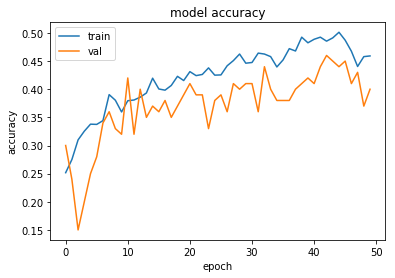

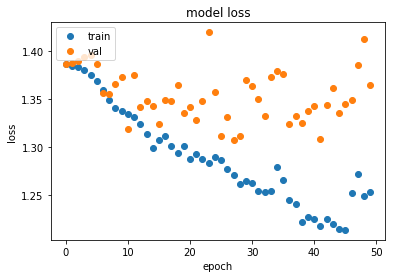

In [47]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'],'o')
plt.plot(history.history['val_loss'],'o')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()